In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
import warnings

warnings.simplefilter(action='ignore')

In [20]:
df = pd.read_csv(
    'serial_wise_sales_data.csv'
    ).sort_values(by='ds')

## EDA

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 499
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ds         1000 non-null   int64  
 1   series_id  1000 non-null   int64  
 2   target     900 non-null    float64
 3   promo      1000 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 39.1 KB


In [4]:
df.describe()

,ds,series_id,target,promo
count,1000.000000,1000.00000,900.000000,1000.000000
mean,249.500000,0.50000,274.368323,0.066000
std,144.409501,0.50025,291.144287,0.357452
min,0.000000,0.00000,0.095018,0.000000
25%,124.750000,0.00000,27.477248,0.000000
50%,249.500000,0.50000,180.488618,0.000000
75%,374.250000,1.00000,459.202051,0.000000
max,499.000000,1.00000,1540.552194,2.000000


In [5]:
df.head(5)

,ds,series_id,target,promo
0,0,0,0.103389,0.0
500,0,1,18.133510,0.0
1,1,0,0.095018,0.0
501,1,1,18.102866,0.0
502,2,1,18.539819,0.0


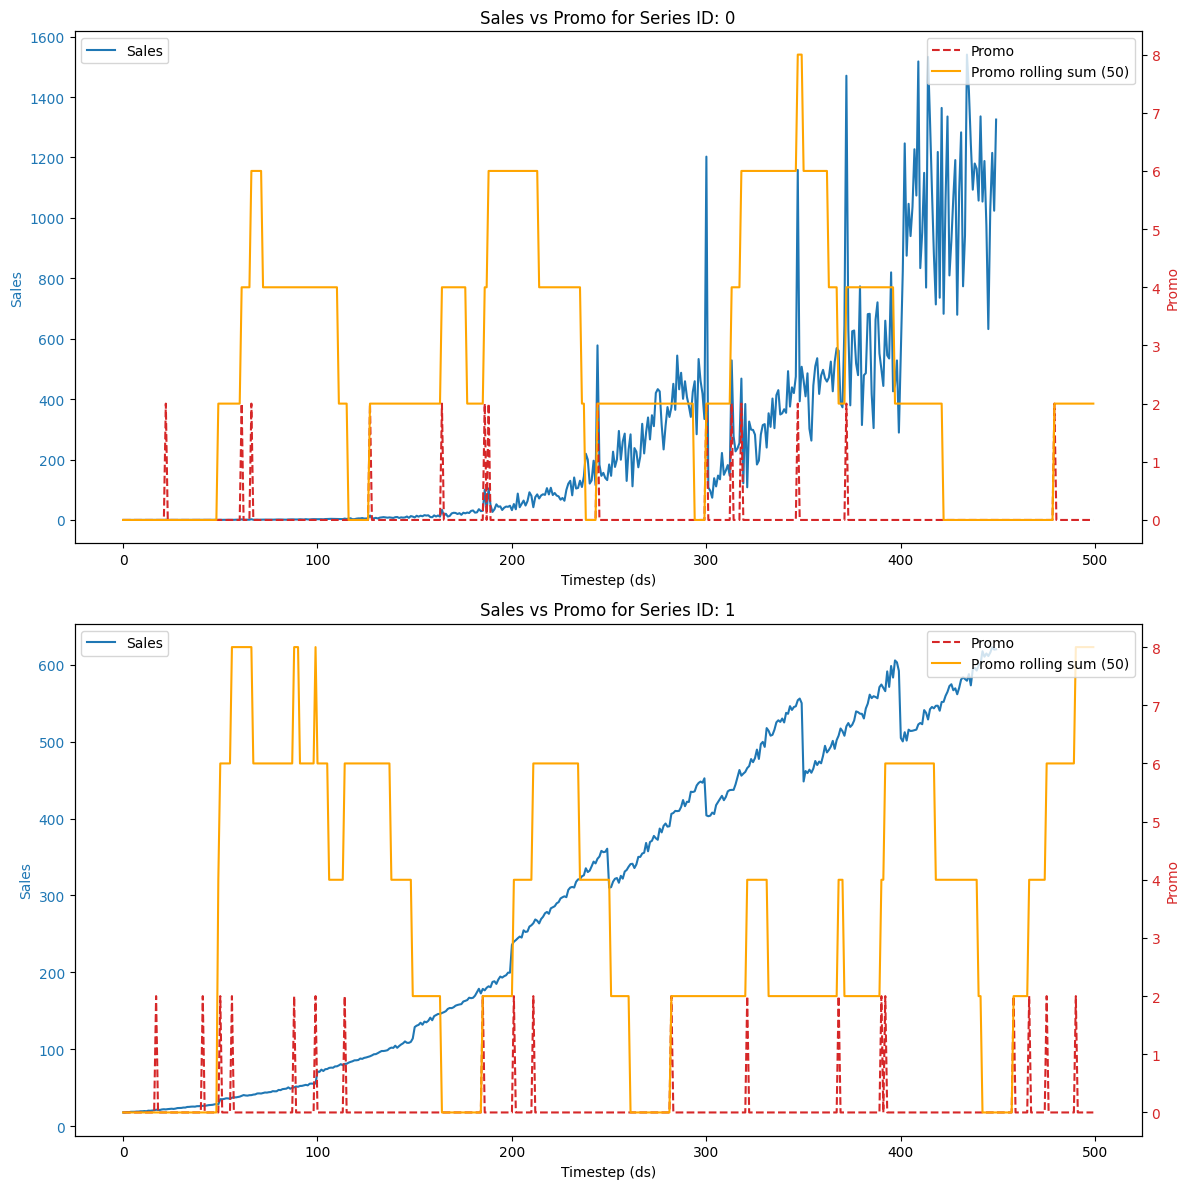

In [6]:
unique_series = df.series_id.unique()
total_series = len(unique_series)

fig, axes = plt.subplots(
    nrows=total_series, ncols=1, figsize=(12, 6 * total_series)
    )

# Ensure axes is iterable, even if there's only one series_id
if total_series == 1:
    axes = [axes]

for idx, series_id in enumerate(unique_series):
    # Filter data for the current series_id
    data = df[df['series_id'] == series_id]
    
    # Plot 'target' on the primary y-axis
    ax = axes[idx]
    ax.plot(data['ds'], data['target'], label='Sales', color='tab:blue')
    ax.set_xlabel('Timestep (ds)')
    ax.set_ylabel('Sales', color='tab:blue')
    ax.tick_params(axis='y', labelcolor='tab:blue')
    
    # Create a twin y-axis for 'promo'
    ax2 = ax.twinx()
    ax2.plot(data['ds'], data['promo'], label='Promo', color='tab:red', linestyle='--')
    ax2.plot(data['ds'], data['promo'].rolling(50).sum().fillna(0), label= 'Promo rolling sum (50)', color='orange')
    ax2.set_ylabel('Promo', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    
    # Add title and legends
    ax.set_title(f'Sales vs Promo for Series ID: {series_id}')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

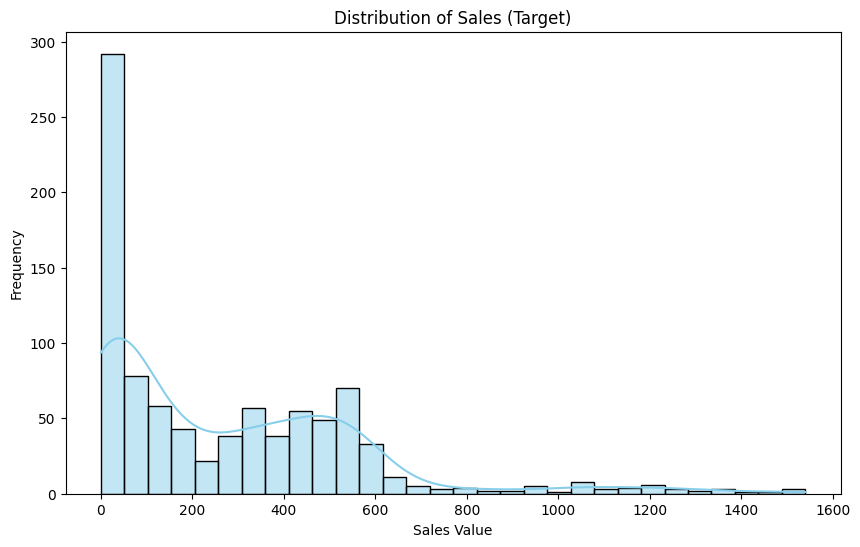

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df['target'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Sales (Target)')
plt.xlabel('Sales Value')
plt.ylabel('Frequency')
plt.show()

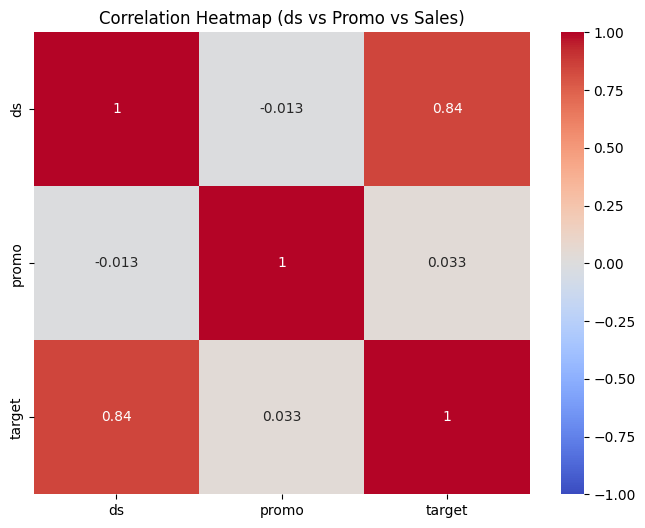

In [8]:
correlation = df[['ds', 'promo', 'target']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap (ds vs Promo vs Sales)')
plt.show()

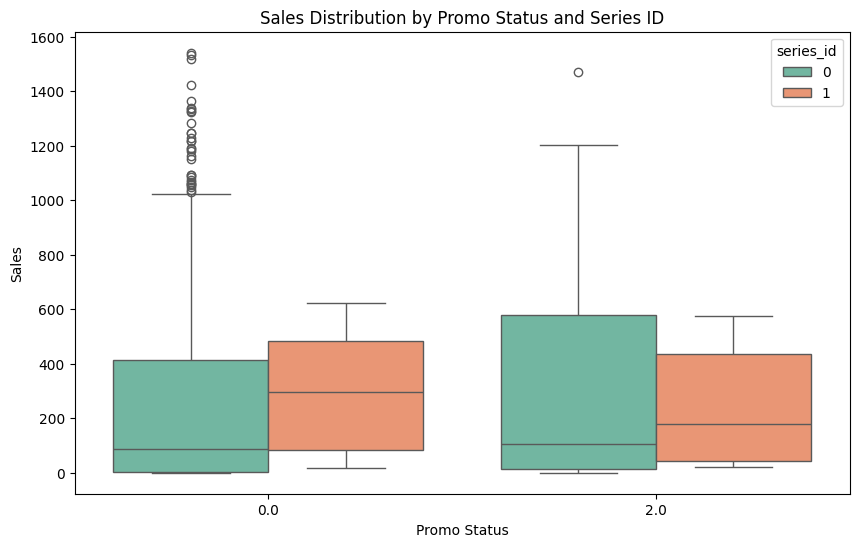

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='promo', y='target', hue='series_id', palette='Set2')
plt.title('Sales Distribution by Promo Status and Series ID')
plt.xlabel('Promo Status')
plt.ylabel('Sales')
plt.show()

Before Differencing


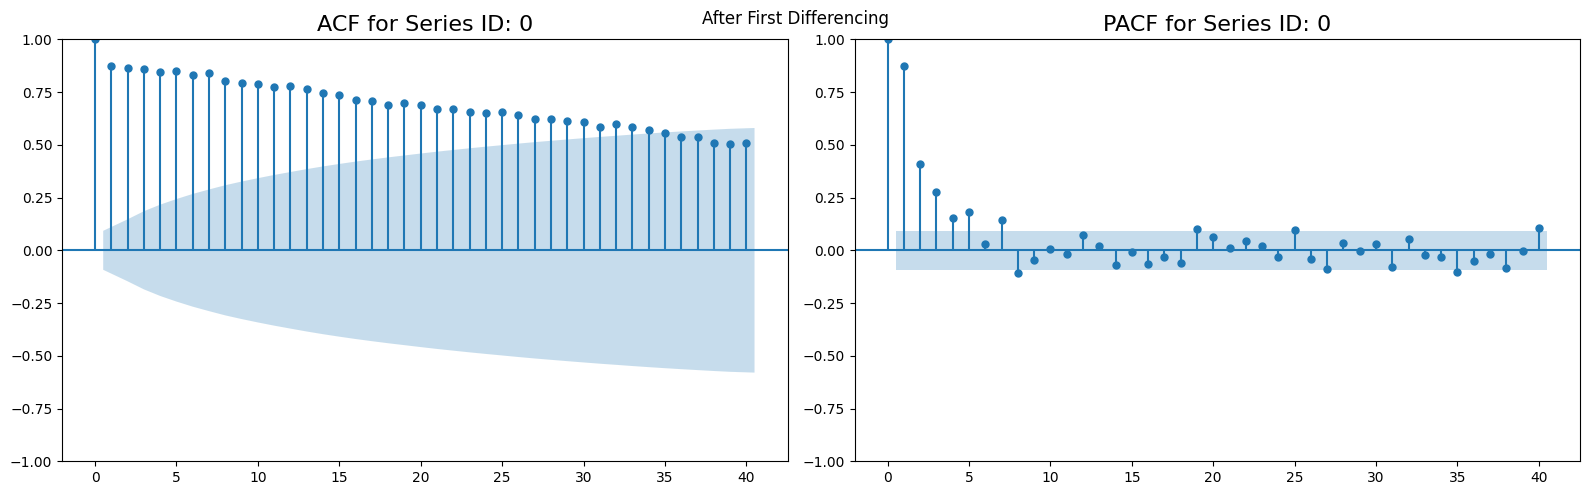

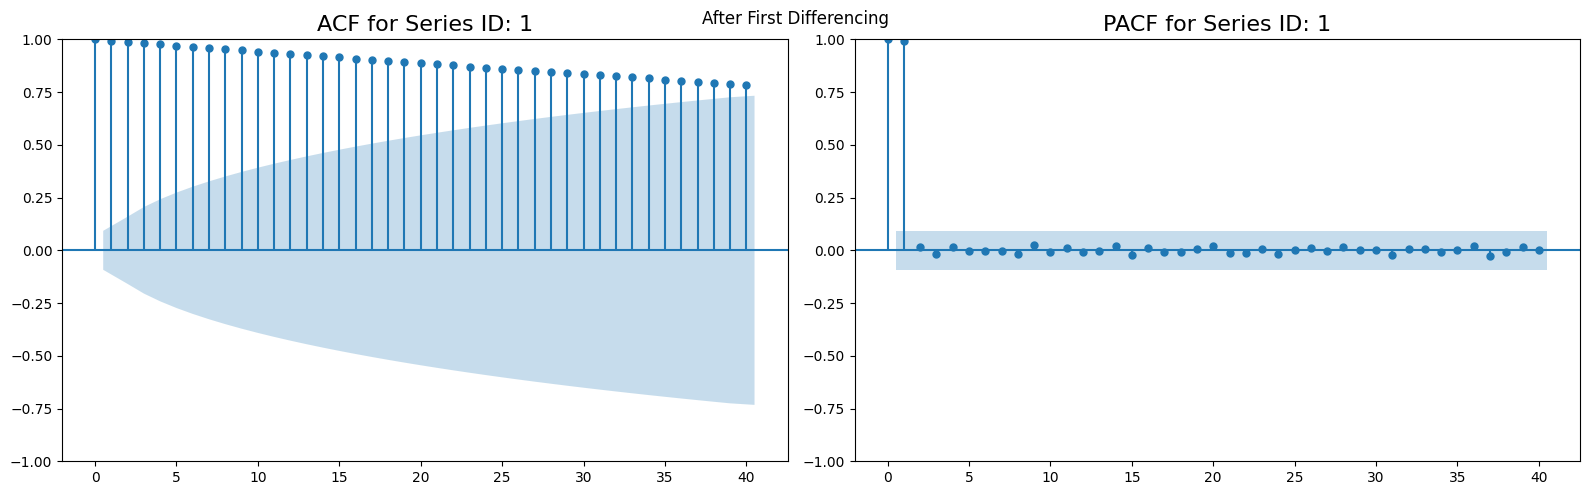

In [10]:
print('Before Differencing')
for series_id in df['series_id'].unique():
    data = df[df['series_id'] == series_id].set_index('ds').dropna()

    # Create subplots for ACF and PACF
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))  # 1 row, 2 columns layout

    # Plot ACF
    plot_acf(data['target'], lags=40, ax=axes[0])
    axes[0].set_title(f'ACF for Series ID: {series_id}', fontsize=16)

    # Plot PACF
    plot_pacf(data['target'], lags=40, ax=axes[1], method='ywm')  # Adjust method for stability
    axes[1].set_title(f'PACF for Series ID: {series_id}', fontsize=16)

    # Adjust layout for a neat appearance
    plt.tight_layout()
    plt.suptitle('After First Differencing')
    plt.show()

After First Differencing


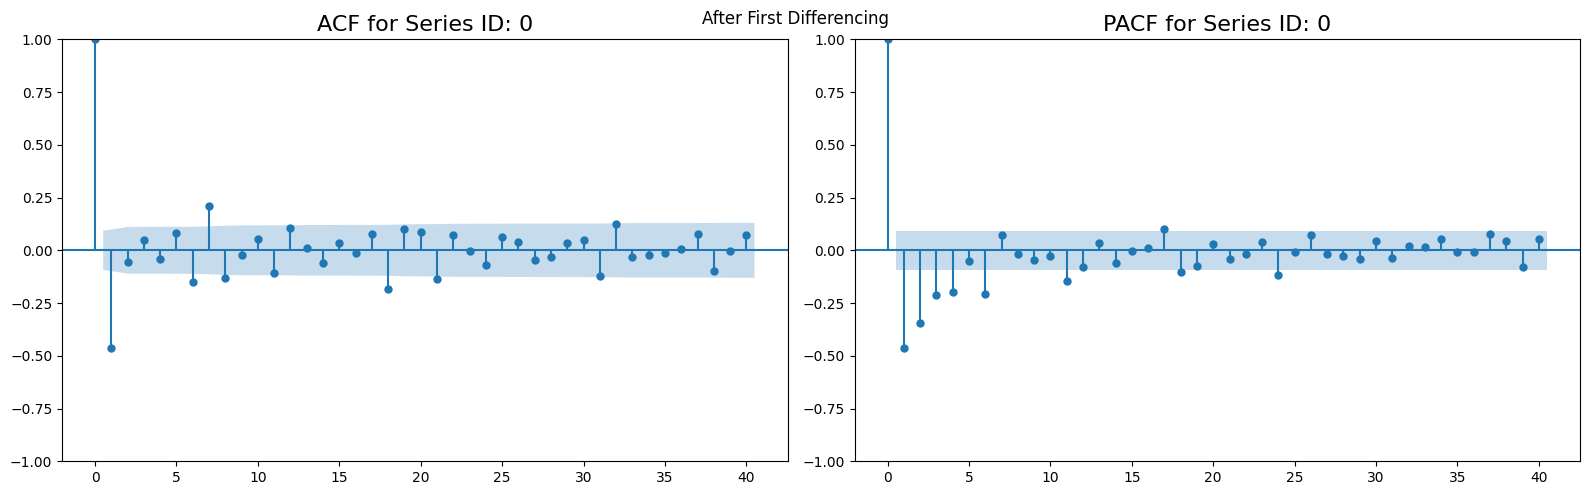

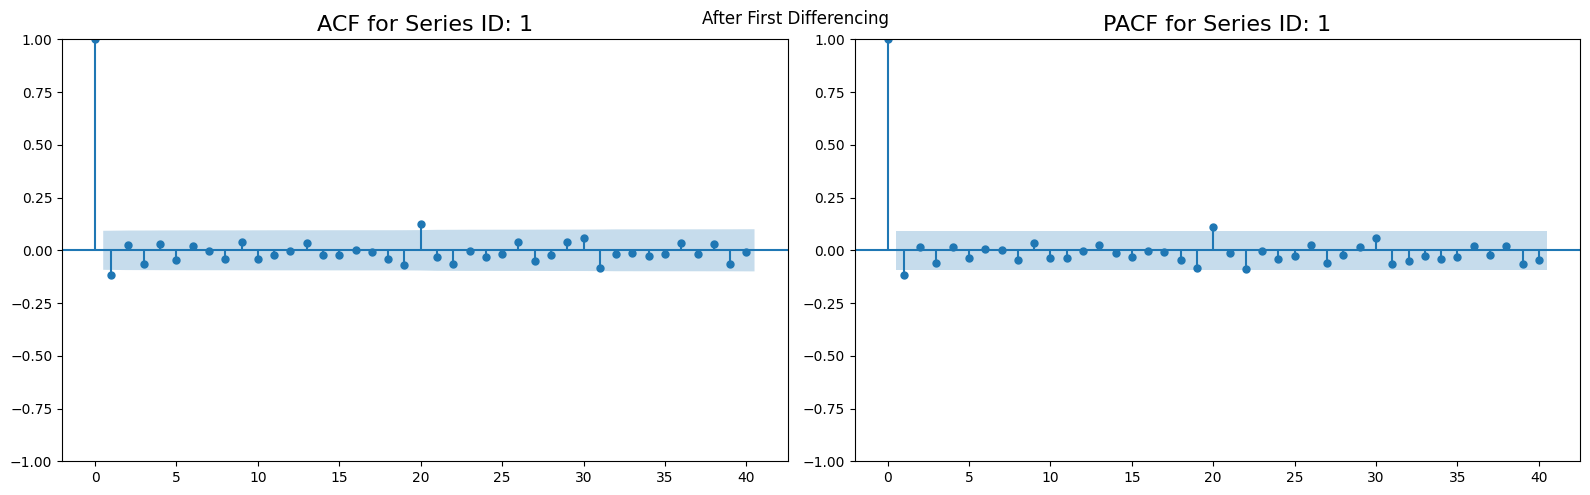

In [11]:
print('After First Differencing')
for series_id in df['series_id'].unique():
    data = df[df['series_id'] == series_id].set_index('ds').dropna()

    # Create subplots for ACF and PACF
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))  # 1 row, 2 columns layout

    # Plot ACF
    plot_acf(data['target'].diff().dropna(), lags=40, ax=axes[0])
    axes[0].set_title(f'ACF for Series ID: {series_id}', fontsize=16)

    # Plot PACF
    plot_pacf(data['target'].diff().dropna(), lags=40, ax=axes[1], method='ywm')  # Adjust method for stability
    axes[1].set_title(f'PACF for Series ID: {series_id}', fontsize=16)

    # Adjust layout for a neat appearance
    plt.tight_layout()
    plt.suptitle('After First Differencing')
    plt.show()

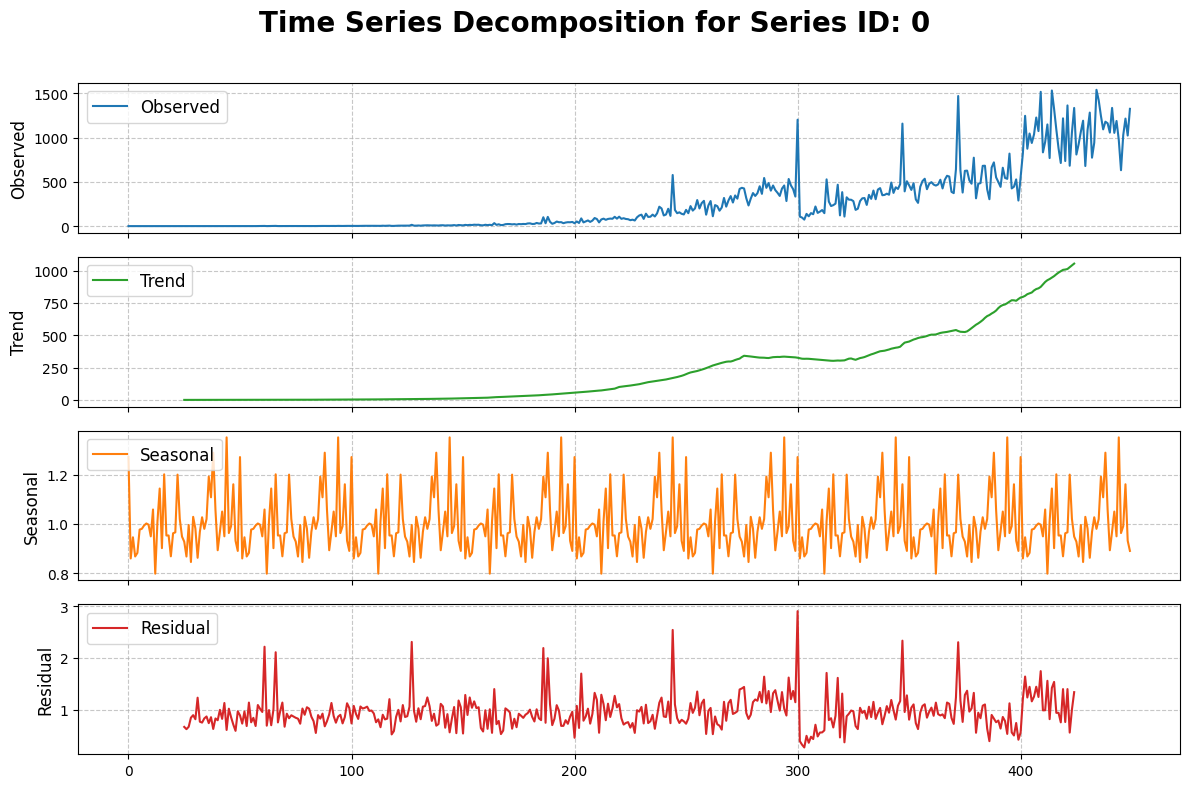

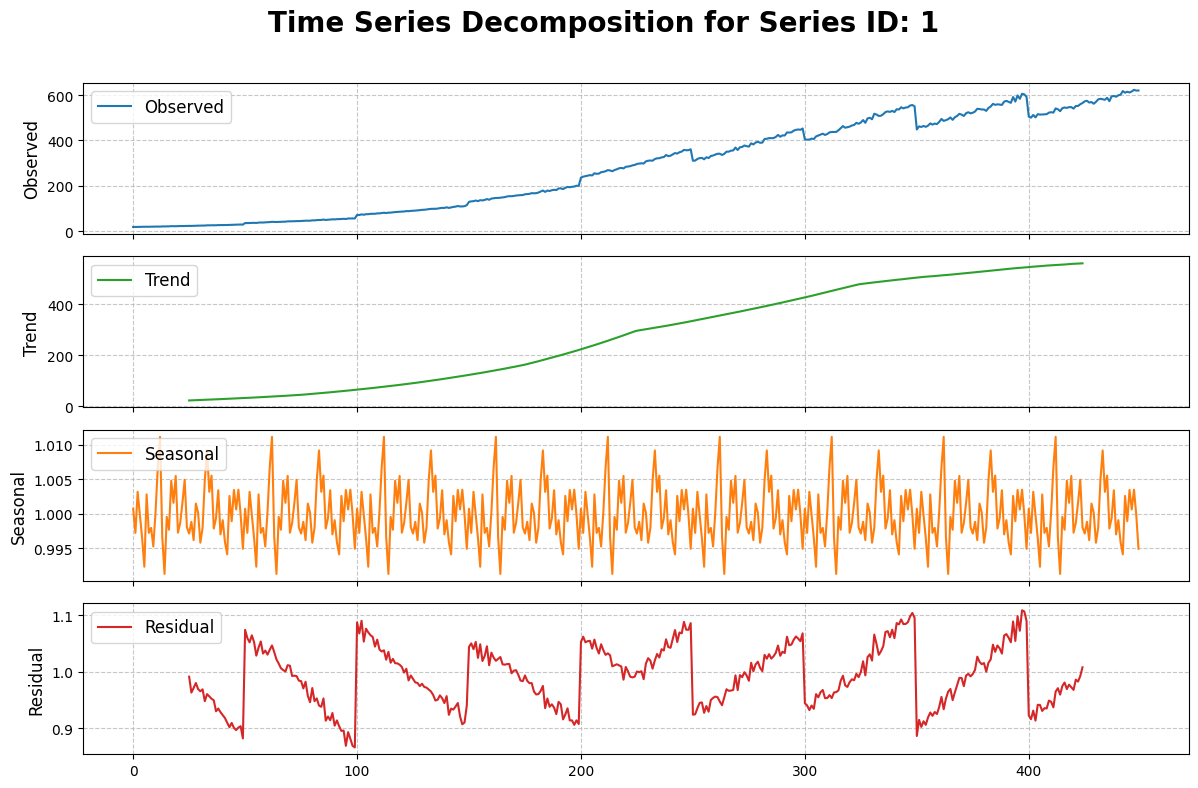

In [12]:
for series_id in df['series_id'].unique():
    # Filter data and set 'ds' as index
    data = df[df['series_id'] == series_id].set_index('ds')
    
    # Perform seasonal decomposition
    result = seasonal_decompose(data['target'].dropna(), model='multiplicative', period=50)

    # Create a figure and customize subplots
    fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
    fig.suptitle(f'Time Series Decomposition for Series ID: {series_id}', fontsize=20, fontweight='bold')
    
    # Plot observed, trend, seasonal, and residual components
    components = ['Observed', 'Trend', 'Seasonal', 'Residual']
    colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']
    

    for i, (ax, comp, color) in enumerate(zip(axes, components, colors)):
        if i == 0:
            ax.plot(result.observed, color=color, label=comp)
        elif i == 1:
            ax.plot(result.trend, color=color, label=comp)
        elif i == 2:
            ax.plot(result.seasonal, color=color, label=comp)
        else:
            ax.plot(result.resid, color=color, label=comp)
        
        ax.legend(loc='upper left', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_ylabel(comp, fontsize=12)
    
    # Final layout adjustments
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title
    plt.show()

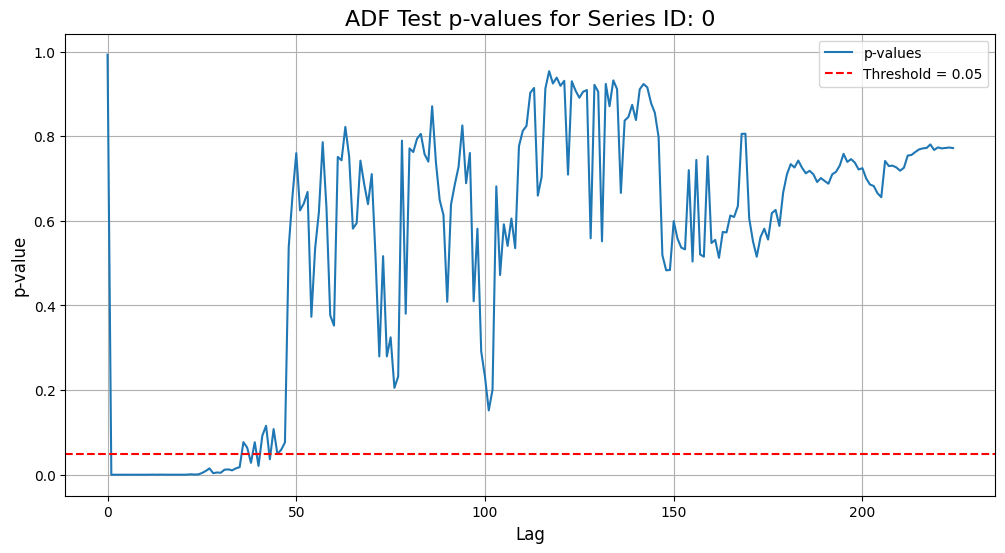

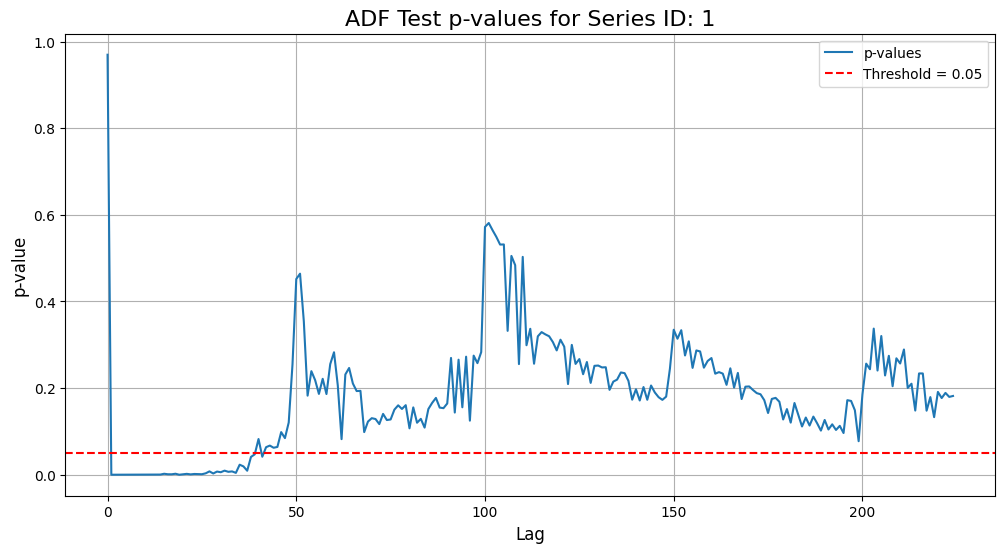

In [13]:
for series_id in df['series_id'].unique():
    data = df[df['series_id'] == series_id].set_index('ds').dropna()
    
    # Calculate p-values over lags
    p_values = [
        adfuller(data.target.diff(i).dropna())[1] if i > 0 
            else adfuller(data.target)[1] 
        for i in range(len(data)//2)
    ]

    # Plot p-values
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(p_values)), p_values, linestyle='-', label='p-values')
    plt.axhline(y=0.05, color='red', linestyle='--', label='Threshold = 0.05')
    
    plt.title(f'ADF Test p-values for Series ID: {series_id}', fontsize=16)
    plt.xlabel('Lag', fontsize=12)
    plt.ylabel('p-value', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

## Model Development and Evaluation

In [14]:
hyperparams = {
    0: {'order': (1, 2, 1), 'seasonal_order': (1, 1, 1, 50)},
    1: {'order': (1, 2, 1), 'seasonal_order': (1, 1, 1, 50)},
}

Summary of SARIMAX model for Series ID 1:
                                     SARIMAX Results                                      
Dep. Variable:                             target   No. Observations:                  360
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 50)   Log Likelihood               -1045.650
Date:                            Thu, 24 Oct 2024   AIC                           2103.300
Time:                                    05:39:59   BIC                           2125.681
Sample:                                         0   HQIC                          2112.249
                                            - 360                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
promo          1.0518      0.539      1.951      0.051      -0.005      

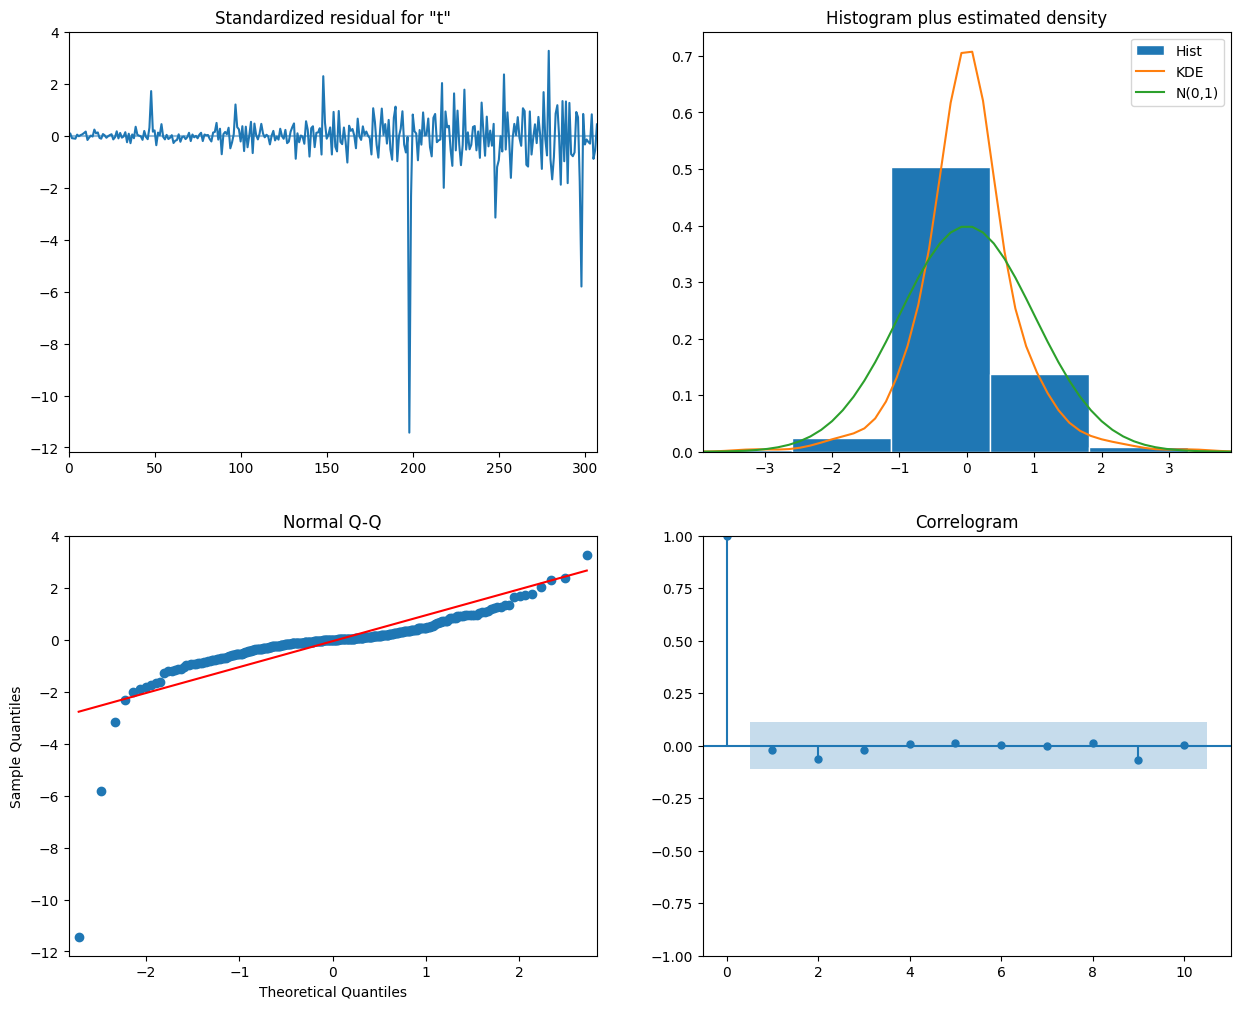

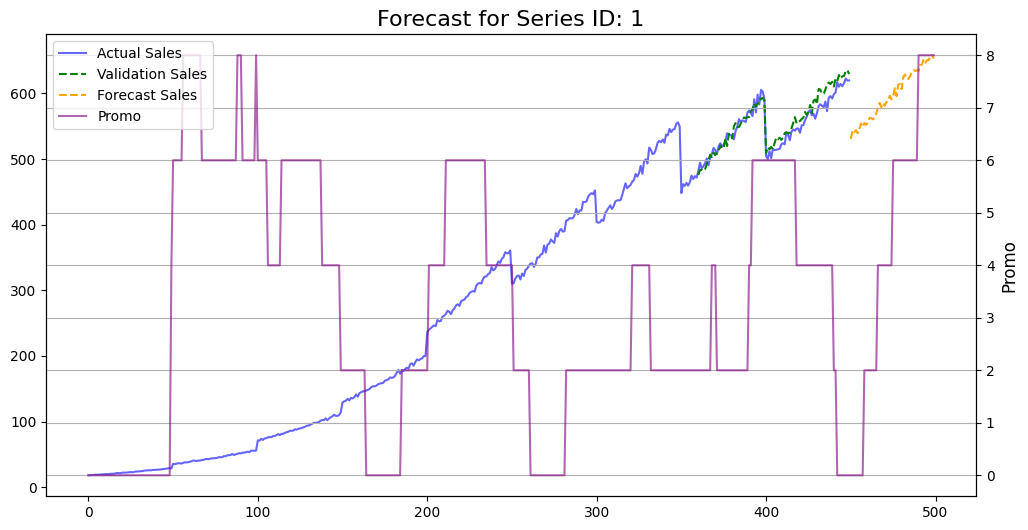

Summary of SARIMAX model for Series ID 0:
                                     SARIMAX Results                                      
Dep. Variable:                             target   No. Observations:                  360
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 50)   Log Likelihood               -1882.871
Date:                            Thu, 24 Oct 2024   AIC                           3777.742
Time:                                    05:40:27   BIC                           3800.123
Sample:                                         0   HQIC                          3786.691
                                            - 360                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
promo         30.3782      6.423      4.730      0.000      17.790      

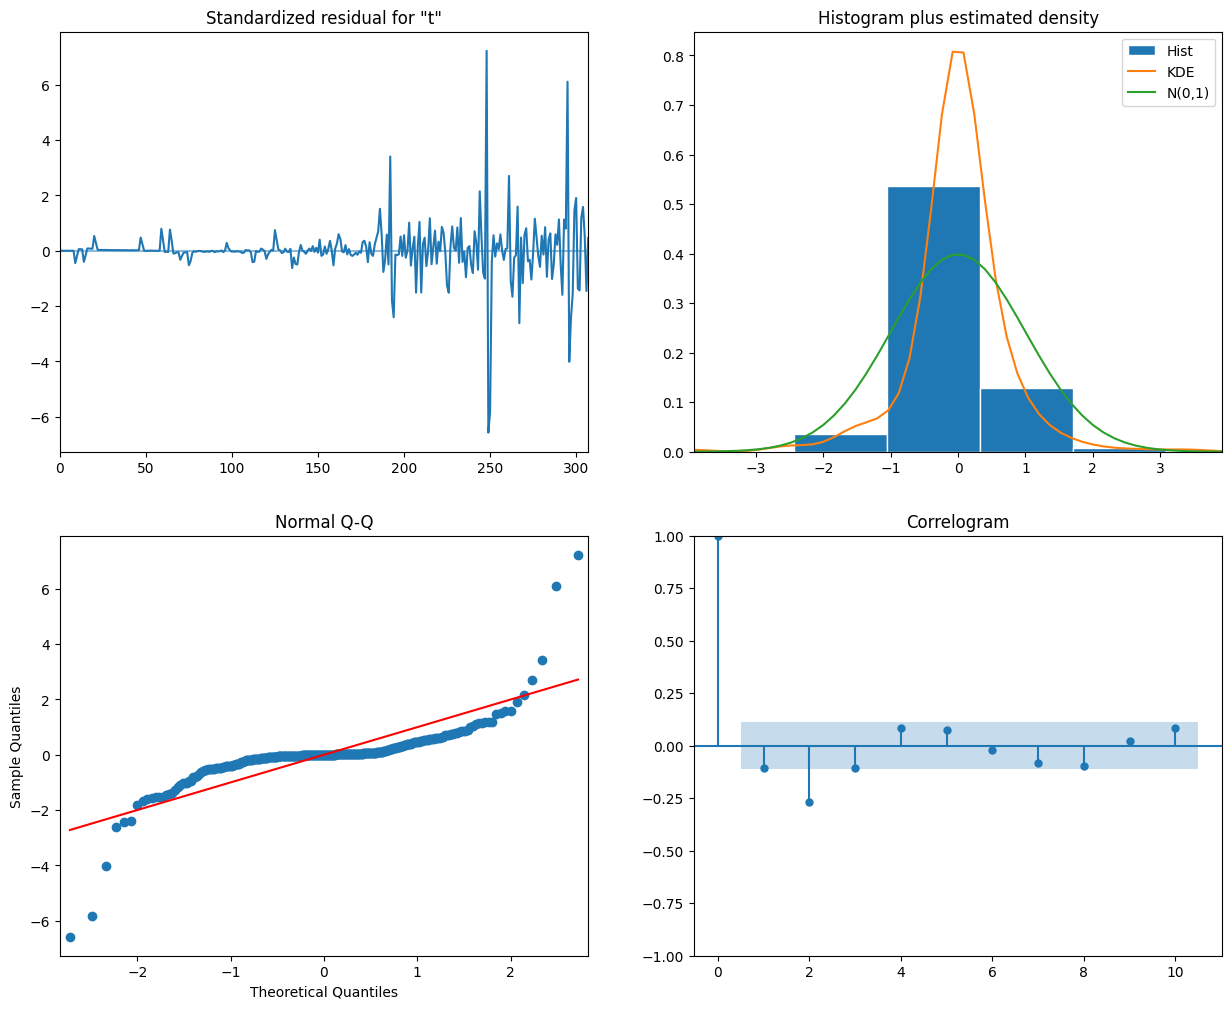

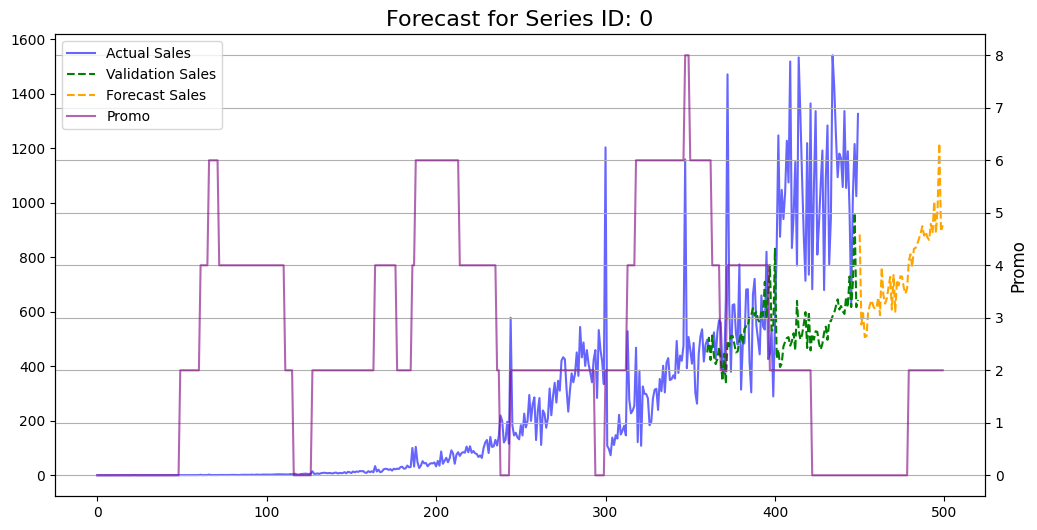

In [15]:
final_df = df.copy()

for series_id in df['series_id'].sort_values(ascending=False).unique():
    data = df[df['series_id'] == series_id].set_index('ds')
    data['promo'] = data['promo'].rolling(50).sum().fillna(0)
    # data['target'] = np.log1p(data['target'])  # Apply log(1 + target)

    # Create train, valid, and test sets
    train = data[data['target'].notna()]  # Training set
    test = data[data['target'].isna()]     # Test set (only where target is NaN)

    # Splitting training set further into train and validation
    train_size = int(len(train) * 0.8)   # 80% of train data for training
    valid = train[train_size:]  # Validation set
    train = train[:train_size]  # Remainder for actual training


    # Fit SARIMAX model using training set and exogenous variable
    model = SARIMAX(train['target'], 
                    order=hyperparams.get(series_id, {}).get('order'),
                    seasonal_order=hyperparams.get(series_id, {}).get('seasonal_order'),
                    exog=train['promo'])
    model_fit = model.fit()

    print(f'Summary of SARIMAX model for Series ID {series_id}:')
    print(model_fit.summary())

    # Forecast the next steps based on the validation and testing set
    forecast_steps = len(valid) + len(test)  # Forecasting for validation and test sets
    exog_forecast = pd.concat([valid['promo'], test['promo']])  # Combine exogenous variables

    # Ensure the correct number of steps is forecasted
    forecast = model_fit.forecast(steps=forecast_steps, exog=exog_forecast)
    forecasted_values = [forecast.iloc[i] for i in range(forecast_steps)]

    # Impute forecasted values directly into final_df
    final_df.loc[(final_df['series_id'] == series_id) & (final_df['target'].isna()), 'target'] = forecasted_values[len(valid):]

    # Calculate error metrics
    mae = mean_absolute_error(valid['target'], forecasted_values[:len(valid)])
    mape = mean_absolute_percentage_error(valid['target'], forecasted_values[:len(valid)]) * 100
    rmse = root_mean_squared_error(valid['target'], forecasted_values[:len(valid)])

    # Print error metrics
    print(f'Error metrics for Series ID {series_id}:')
    print(f'Mean Absolute Error (MAE): {mae:.2f}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
    print(f'Root Mean Squared Error (RMSE): {rmse:.2f}\n')

    # model diagnosis
    model_fit.plot_diagnostics(figsize=(15, 12))
    
    # Create a DataFrame for the forecast
    last_timestamp = train.index[-1]
    forecast_index = [last_timestamp + i for i in range(1, forecast_steps + 1)]  # Keep it as integer
    forecast_df = pd.DataFrame(forecasted_values, index=forecast_index, columns=['Forecast'])

    # Adjust test DataFrame to include only the forecast index
    test_index = forecast_df.index[-len(test):]  # Ensure it matches the forecast length
    forecast_df = forecast_df.tail(len(test))  # Keep only the last n forecasted values matching test length

    # Plot actual vs forecasted values
    plt.figure(figsize=(12, 6))

    # Plot actual sales
    line_actual, = plt.plot(data.index, data['target'], label='Actual Sales', color='blue', alpha=0.6)

    # Plot validation sales
    line_valid, = plt.plot(valid.index, forecasted_values[:len(valid)], label='Validation Sales', color='green', linestyle='--')

    # Plot forecast sales
    line_forecast, = plt.plot(test_index, forecast_df['Forecast'], label='Forecast Sales', color='orange', linestyle='--')

    # Create twin axis for promo
    ax2 = plt.gca().twinx()  # Create a twin Axes sharing the x-axis
    line_promo, = ax2.plot(data.index, data['promo'], label='Promo', color='purple', linestyle='-', alpha=0.6)

    # Set titles and labels
    plt.title(f'Forecast for Series ID: {series_id}', fontsize=16)
    plt.xlabel('Timestamp', fontsize=12)
    plt.ylabel('Sales', fontsize=12)
    ax2.set_ylabel('Promo', fontsize=12)

    # Combine legends from both axes
    lines = [line_actual, line_valid, line_forecast, line_promo]  # All lines
    labels = [line.get_label() for line in lines]  # Get labels from the lines

    # Display the legend with all unique labels
    plt.legend(lines, labels, loc='upper left')

    plt.grid(True)
    plt.show()


In [17]:
final_df.to_csv('output.csv', index=False)